# 1.část – Získání dat pomocí Spotify API a MusicBrainz API

Tato část není potřeba spouštět, její výstup je totiž nahrán v samostatném souboru. Pokud byste tuto část chtěli spustit, potřebujete nejprve vytvořit nový projekt na https://developer.spotify.com/. \
Připojení ke Spotify API je na stejném portu, kde se spouští Jupyter Notebook. Pokud tedy spouštíte Jupyter z terminálu, je nutné ho spustit pomocí: jupyter notebook --port 9999 (za 9999 dosaďte jakékoliv číslo)

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import musicbrainzngs as music_api  # API databáze s umělci

In [3]:
# Tyto proměnné je třeba doplnit
# Je nutné vytvořit nový projekt na https://developer.spotify.com/ a zjistit ID a token uživatele
my_id = "" # Client ID
my_token = ""  # Client secret

In [4]:
# Funkce, která zprostředkovává připojení ke Spotify API
def init_spotipy():
    scope = "user-library-read user-top-read"
    redirect_uri = "http://localhost:8888/callback"
    return spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, client_id=my_id, client_secret=my_token, redirect_uri=redirect_uri))

In [5]:
# Tato funkce vrátí seznam věech umělců

def get_top_artists(sp, limit, _range):
    artists_json = sp.current_user_top_artists(limit=limit, time_range=_range)
    
    artists_set = set()
    for artist in artists_json["items"]:
        artist_name = artist["name"]
        artists_set.add(artist_name)
    return artists_set

In [33]:
# Hledání zemí umělců v databázi MusicBrainz

music_api.set_useragent(app="Mapping top artists areas", version="0.1")
def find_countries(artists_names):
    countries = dict()
    not_found = []
    
    for artist_name in artists_names:
        # Ze jména umělce zjistí jeho ID
        try:
            artist_id = music_api.search_artists(artist_name)["artist-list"][0]["id"]
        except Exception:
            print("Umělec nebyl nalezen v databázi MusicBrainz")
            continue
        
        # Najde umělce podle ID
        try:
            result = music_api.get_artist_by_id(artist_id)
        except WebServiceError as e:
            print(f"Něco se pokazilo při hledání umělce na MusicBrainz.\n {e}")
            continue
        
        # U nalezeného umělce zjistí zemi
        try:
            countries[artist_name] = result["artist"]["area"]["name"]
        except Exception:
            print(f"Pro umělce {artist_name} se nenašla země")
            not_found.append(artist_name)
            continue
            
    # Vypíše všechny umělce, u kterých nebyla nalezena jejich země
    if not_found != []:
        print("Pod tuto buňku vložte (zaměňte ZEMĚ za skutečný stát):")
        for item in not_found:
            print(f'artists_countries["{item}"] = "ZEMĚ"')
    return countries

In [29]:
# Uloží výsledek do souboru
def save_artists_countries(artists_dict):
    with open("Data/artists_countries.csv", "w", encoding="utf-8") as file:
        for artist, country in artists_dict.items():
            file.write(f"{artist},{country}\n")


In [38]:
# Provedení funkcí z buněk výše

spotify = init_spotipy() # Připojí se ke Spotify API
artists = get_top_artists(spotify, limit=150, _range="long_term") # Zjistí oblíbené umělce
artists_countries = find_countries(artists)  # Pro umělce najde jejich zemi

Pro umělce Hollow Coves se nenašla země
Pro umělce Cruskin se nenašla země
Pro umělce Ben Laver se nenašla země
Pod tuto buňku vložte (zaměňte ZEMĚ za skutečný stát):
artists_countries["Hollow Coves"] = "ZEMĚ"
artists_countries["Cruskin"] = "ZEMĚ"
artists_countries["Ben Laver"] = "ZEMĚ"


In [40]:
# Ruční doplnění zemí
artists_countries["Hollow Coves"] = "Australia"
artists_countries["Cruskin"] = "France"
artists_countries["Ben Laver"] = "United Kingdom"
artists_countries["Lenny"] = "Czech Republic"
artists_countries

{'Hans Zimmer': 'United States',
 'Johnny Cash': 'United States',
 'The Piano Guys': 'United States',
 'Lenny': 'Czech Republic',
 'First Aid Kit': 'Sweden',
 'Enya': 'Ireland',
 'Imagine Dragons': 'United States',
 'Queen': 'United Kingdom',
 'Coldplay': 'United Kingdom',
 'Nightwish': 'Finland',
 'Alan Silvestri': 'United States',
 'David Guetta': 'France',
 'Robbie Williams': 'United Kingdom',
 'Dan Le Sac vs Scroobius Pip': 'United Kingdom',
 'Lana Del Rey': 'United States',
 'Ludovico Einaudi': 'Italy',
 'TheFatRat': 'United States',
 'Two Steps from Hell': 'United States',
 'Apocalyptica': 'Finland',
 'Enigma': 'Germany',
 'Amy Macdonald': 'United Kingdom',
 'Vangelis': 'Greece',
 'Therion': 'Sweden',
 'Ivo Jahelka': 'Czech Republic',
 'Of Monsters and Men': 'Iceland',
 'Adrian Von Ziegler': 'Switzerland',
 'U2': 'Ireland',
 'Xandria': 'Bielefeld',
 'Epica': 'Netherlands',
 'Pokáč': 'Czech Republic',
 'Pink Floyd': 'United Kingdom',
 'Ennio Morricone': 'Italy',
 'The Cranberries'

In [42]:
save_artists_countries(artists_countries)  # Uložení výsledku do souboru

# 2. část – Tvorba mapy z uložených dat

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [7]:
# Ze souboru načte data o umělcích 
artists_df = pd.read_csv("Data/artists_countries.csv", header=None)
artists_df.columns = ["Artist", "Country"]

# Načtení mapy
countries = gpd.read_file("Data/world_map/World_Map.shp").to_crs(epsg=3395)

In [8]:
# Oprava států, které nebyly zapsány správně
print("Státy nebo místa, které nebyly nalezeny na mapě (můžete opravit v buňce níže):")
artists_df[-artists_df.Country.isin(countries["NAME"])]

Státy nebo místa, které nebyly nalezeny na mapě (můžete opravit v buňce níže):


,Artist,Country
27,Xandria,Bielefeld


In [9]:
artists_df.replace({"Bielefeld":"Germany"}, inplace=True)

In [11]:
# Do tabulky jednotlivých zemí přidá nový sloupec, který obsahuje umělce z dané země
def add_artists(row):
    if row["NAME"] in grouped.groups:
        row["Artists"] = grouped.get_group(row["NAME"])["Artist"].values
    else:
        row["Artists"] = None
    return row


In [13]:
# Vytvoření výsledné tabulky

# Tabulku umělců rozdělí do skupin podle zemí
grouped = artists_df.groupby(["Country"])

# Doplní do tabulky zemí počty umělců
merged_countries = countries.merge(grouped.count(), left_on="NAME", right_on="Country", how="left").fillna(0)

merged_countries["Artist"] = merged_countries["Artist"].astype(int)
merged_countries = merged_countries.rename(columns={"Artist": "Artists_count"})

# Do tabulky se zeměmi doplní sloupec se jmény umělců, kteří z dané země pocházejí
merged_countries = merged_countries.apply(add_artists, axis=1)

merged_countries[merged_countries["NAME"] == "Czech Republic"] # Otestování, že vše proběhlo v pořádku – vypíše řádek pro Česko

,NAME,geometry,Artists_count,Artists
57,Czech Republic,"POLYGON ((1636427.684 6172067.300, 1631541.538...",4,"[Lenny, Ivo Jahelka, Pokáč, Lake Malawi]"


In [20]:
from shapely.geometry.point import Point
from matplotlib import rc
from matplotlib.backend_bases import MouseButton
rc('text', usetex=True)  # Toto je nutné pro formátování popisků


# Po kliknutí myší najde v tabulce řádek země, na kterou bylo kliknuto 
def find_row(point):
    for index, row in merged_countries.iterrows():
        if row.geometry.contains(point):
            return row

# Po kliknutí vytvoří popisek / nebo ho smaže (zobrazení popisku trvá poměrně dlouho)
def make_label(event, fig, text):
    if event.button is MouseButton.LEFT:
        # Pokud bylo kliknuto levým tlačítkem, vytvoří se na pozici kurzoru nový bod a podle něho se v tabulce najde země
        clicked_point = Point(event.xdata, event.ydata)
        row = find_row(clicked_point)
        
        # Pokud se našla země
        if row is not None:
            if row["Artists"] is not None: # Když v dané zemi nejsou žádní umělci, je její název podtržen
                text.set_text(r"$\textbf{\underline{" + row["NAME"] + "}}$" + "\n" + "\n".join(row["Artists"]))
            else:
                # Do popisku se napíše text
                text.set_text(r"$\textbf{" + row["NAME"] + "}$" + "\nNo artist")
            text.set_position((event.xdata, event.ydata)) # Umístění popisku na pozici myši
            text.set_visible(True) # Zviditelnění popisku
    else:
        text.set_visible(False)
        # Pokud bylo kliknuto prostředním nebo pravým tlačítkem, popisek se zneviditelní 
        
    fig.canvas.draw()  # Mapa se musí vykreslit znovu, aby se zobrazil popisek

In [21]:
%matplotlib auto

# Místo pro graf
fig, ax = plt.subplots(figsize=(18, 16))

# Vytvoří se objekt popisku - pro všechny popisky se používá jenom jeden, který se přesouvá a přepisuje
text_object = ax.text(0.0, 0.0, "", style='normal', fontsize=17,
        bbox={'facecolor': 'red', 'alpha': 0.9, 'pad': 10})
text_object.set_visible(False)

# Nastaví, že po kliknutí myši se spustí funkce make_label()
plt.connect("button_press_event", lambda event: make_label(event, fig, text_object))

# Vytvoří mapu
merged_countries.plot(ax=ax, column="Artists_count", 
                      cmap="Greys", edgecolor="black", 
                      linewidth=0.2, legend=True,
                      legend_kwds={"label":"Počet oblíbených umělců", "orientation": "vertical"}
                     )

plt.axis("off")  # Zruší popisky os x a y 

# Vytvoří seznam hodnot, které se zobrazí v menu
area_options = ["world"] + sorted(merged_countries[merged_countries.Artists_count > 0].NAME.to_list())

@widgets.interact  # Vytvoří menu, z kterého lze vybrat zemi, která se má na mapě přiblížit
def choose_area(Country=area_options):
    if Country != "world": 
        selected_data = merged_countries[merged_countries.NAME == Country]
    else: # Při kliknutí na možnost world se zobrazí všehny státy
        selected_data = merged_countries
        
    # Přiblížení na danou zemi (funguje jenom při spuštění v samostatném okně)
    minx, miny, maxx, maxy = selected_data.total_bounds
    ax.set_xlim(minx * 0.95, maxx * 1.05)
    ax.set_ylim(miny * 0.95, maxy * 1.05)
    
    # Zobrazí tabulku s umělci z dané země
    display(artists_df[artists_df.Country.isin(selected_data.NAME)].groupby("Country").apply(lambda a: a.reindex(index=a["Artist"]).drop(["Country", "Artist"], axis=1)[:]))


Using matplotlib backend: Qt5Agg


interactive(children=(Dropdown(description='Country', options=('world', 'Australia', 'Canada', 'Czech Republic…

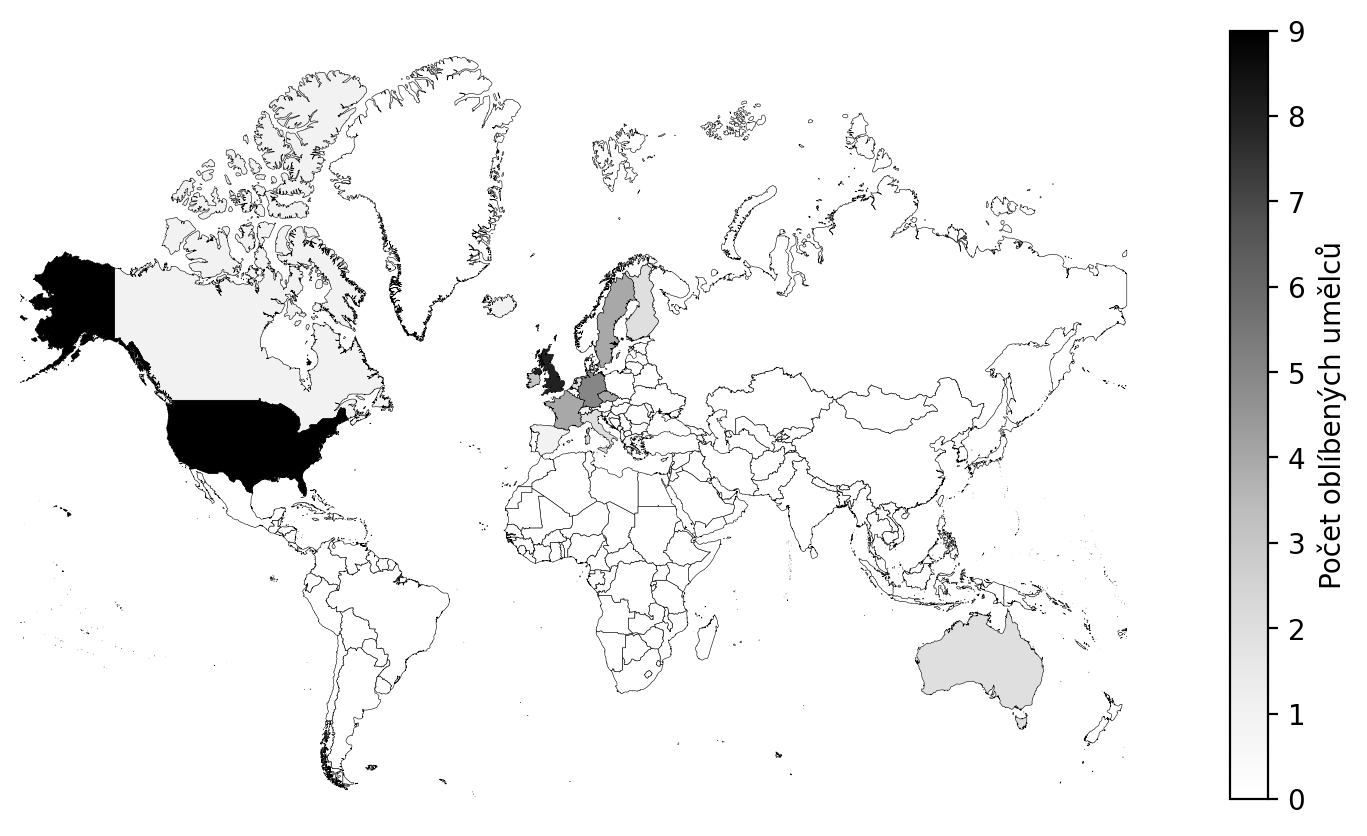

In [19]:
# Zobrazení mapy v Jupyter Notebooku
# Nelze přibližovat země ani zobrazovat popisky
%matplotlib inline
minx, miny, maxx, maxy = merged_countries.total_bounds
ax.set_xlim(minx * 0.95, maxx * 1.05)
ax.set_ylim(miny * 0.95, maxy * 1.05)
fig